**Disclaimer:** This notebook is a work in progress. I'm not (even close to) a specialist in the field of NLP, nor Linguistics (not even English, as it's not my first language). Therefore, keep in mind that the aim of this notebook is to share some cool stuff that I've learned recently and encourage you to contribute to this work, so we can make it even better as a community! Enjoy :)

# Text difficuly sorting

The main objective of this notebook is to create an automated method to rank different types of texts, which will be a great tool to help second-language English learners. We'll explore different Reading Scores, such as the Flesch and Flesch-Kincaid's, and also the Gunning Fog Index. Besides, we'll look at different methods to determine the Lexical Diversity of a text, which can tell us a lot about the range of vocabulary an English learner needs to understand a certain text.

We'll use several NLP libraries, such as ```nltk``` (Natural Language Toolkit) for basic NLP functions, ```spacy``` for lemmatization and POS tagging, ```cmudict``` for syllabic division, and ```lexical-diversity``` to compute different LD functions.

In [12]:
!pip install nltk
!pip install spacy
!pip install cmudict
!pip install lexical-diversity

import nltk
nltk.download('punkt') #extra nltk resources we'll need to install

     |████████████████████████████████| 942kB 5.5MB/s 
     |████████████████████████████████| 122kB 6.1MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Text samples

We'll use 3 text samples to empirically test the accuracy of each Readability Score and Lexical Diversity method. These samples come from the website *newsinlevels*, which provides to the reader the same text in 3 different levels of English. The news we're going to use is "Smallest Monkeys in the World".

>### Level 1
>This news is about monkeys. It is about the smallest monkeys in the world. The smallest monkeys are only 100 grams heavy. There aren’t many of these monkeys in the wild. They are in danger because people are destroying forests.  
>A zoo in Sydney wants to help the monkeys. The zoo puts together two monkeys. It lets them have a family.  
>Two baby monkeys are born. They are beautiful and they are very, very small. They are just 15 grams heavy. They are smaller than your thumb. 
>(https://www.newsinlevels.com/products/smallest-monkeys-in-the-world-level-1/)

>### Level 2
>The smallest monkey in the world weighs only 100 grams. That is as much as an apple. The species is endangered because people are destroying the forests where this type of monkey lives.  
>A zoo in Sydney is trying to help the species survive. Zoo keepers put together two monkeys to start a monkey family. A year later, two lovely monkeys were born. They weigh just 15 grams and are smaller than a human thumb!  
>The monkeys are really cute. Check out their video!  
>(https://www.newsinlevels.com/products/smallest-monkeys-in-the-world-level-2/)

>### Level 3
>Two tiny and absolutely adorable baby pygmy marmosets were born at Sydney’s Symbio Wildlife Park.  
>They weighed just 15 grammes at birth (and were the size of human thumbs) but giving birth to them was, from the mother’s perspective, comparable to a human giving birth to a ten-year-old child.  
>Their proud parents Gomez and IT were introduced to each other the previous year, when IT, the female, arrived at the zoo. Years of bachelorhood ended for Gomez and the two started a family. Apart from their baby monkeys being very cute, their birth is necessary for the ongoing survival of the endangered species.  
>They are members of the world’s smallest monkey species, with adults weighing in at around the same weight as an average apple, just 100 grammes. They are facing extinction due to deforestation and illegal pet trade.   
>(https://www.newsinlevels.com/products/smallest-monkeys-in-the-world-level-3/)

In [13]:
txt = ['''This news is about monkeys. It is about the smallest monkeys in the world. The smallest monkeys are only 100 grams heavy. There aren’t many of these monkeys in the wild. They are in danger because people are destroying forests.
A zoo in Sydney wants to help the monkeys. The zoo puts together two monkeys. It lets them have a family.
Two baby monkeys are born. They are beautiful and they are very, very small. They are just 15 grams heavy. They are smaller than your thumb.
'''.capitalize(), '''The smallest monkey in the world weighs only 100 grams. That is as much as an apple. The species is endangered because people are destroying the forests where this type of monkey lives.
A zoo in Sydney is trying to help the species survive. Zoo keepers put together two monkeys to start a monkey family. A year later, two lovely monkeys were born. They weigh just 15 grams and are smaller than a human thumb!
The monkeys are really cute. Check out their video!
'''.capitalize(),  '''Two tiny and absolutely adorable baby pygmy marmosets were born at Sydney’s Symbio Wildlife Park.
They weighed just 15 grammes at birth (and were the size of human thumbs) but giving birth to them was, from the mother’s perspective, comparable to a human giving birth to a ten-year-old child.
Their proud parents Gomez and IT were introduced to each other the previous year, when IT, the female, arrived at the zoo. Years of bachelorhood ended for Gomez and the two started a family. Apart from their baby monkeys being very cute, their birth is necessary for the ongoing survival of the endangered species.
They are members of the world’s smallest monkey species, with adults weighing in at around the same weight as an average apple, just 100 grammes. They are facing extinction due to deforestation and illegal pet trade.
'''.capitalize()]

# Statistics

First, we'll write some functions to get some text statistics. The information we're going to need:

- Number of sentences
- Number of *tokens* (words, without numbers)
- Number of *types* (unique tokens)
- Average sentence length
- Type/Token ratio
- Number of syllables
- Number of *difficult words* (words with more than 2 syllables)
- Percentage of difficult words
- Average syllables per sentence
- Average syllables per word

## 1. Number of sentences

Pretty straightforward, we'll only need to use nktk's *sent_tokenize*.

In [14]:
import nltk

def sentence_count(txt):
  return len(nltk.sent_tokenize(txt))

for i in range(len(txt)):
    print("Text "+str(i)+" sentence count: "+str(sentence_count(txt[i])))

Text 0 sentence count: 12
Text 1 sentence count: 9
Text 2 sentence count: 7


We see that the easier the text, the more sentences it has. It might be a sign that the more difficult texts have longer sentences, structured in a more ellaborate way.

Extra: number of verses

In [15]:
def verse_count(txt):
  return len([a for a in txt.split('\n') if a != ''])

for i in range(len(txt)):
    print("Text "+str(i)+" verse count: "+str(verse_count(txt[i])))

Text 0 verse count: 3
Text 1 verse count: 3
Text 2 verse count: 4


In [16]:
def strophe_count(txt):
  return len([a for a in txt.split('\n') if a == '']) + 1

#strophe_count(kids_songs[0])

In [17]:
def verses_per_strophe(txt):
  return verse_count(txt)/strophe_count(txt)

#verses_per_strophe(kids_songs[0])

## 2. Number of tokens

Here, we can use nltk's *word_tokenize*, but it won't be sufficient to exclude punctuation and numbers. Therefore, we'll use Python's regex built-in library, *re*, to exclude any digits, then the *isalpha* function to eliminate punctuation. We separate the "token no nums" function from its count function because the first is going to be useful for later.

In [18]:
import re

def tokens_no_nums(txt):
  txt = re.sub('\d', '', txt)
  tokens = nltk.word_tokenize(txt)
  words = [word for word in tokens if word.isalpha()]
  return words

def token_count(txt):
  return len(tokens_no_nums(txt))

for i in range(len(txt)):
    print("Text "+str(i)+" token count: "+str(token_count(txt[i])))

Text 0 token count: 86
Text 1 token count: 82
Text 2 token count: 139


Although we see an unexpected decrease in the number of tokens between the easy and medium levels, the difference is very subtle and will probably be corrected by the type count. There is a significant increase between both the first levels to the difficult level.

## 3. Number of types

For this function, the easier way is to use Python's Counter, which creates a dictionary with the frequency count of each element of the tokens array.


In [19]:
from collections import Counter

def type_count(txt):
  counter = Counter(tokens_no_nums(txt))
  return len(counter.keys())

for i in range(len(txt)):
    print("Text "+str(i)+" type count: "+str(type_count(txt[i])))

Text 0 type count: 51
Text 1 type count: 60
Text 2 type count: 92


As we expected, the number of types is increasing between every level, which can show the difference in vocabulary ranges.

## 4. Average sentence length
Since we already have functions for the number of tokens and sentences, we can use them to compute a simple division.

In [20]:
def avg_sentence_length(txt):
  return token_count(txt)/sentence_count(txt)

for i in range(len(txt)):
    print("Text "+str(i)+" average sentence length: "+str(avg_sentence_length(txt[i])))

Text 0 average sentence length: 7.166666666666667
Text 1 average sentence length: 9.11111111111111
Text 2 average sentence length: 19.857142857142858


Difficult texts have longer and more ellaborate sentences when compared to easier texts, as we have predicted before.

## 5. Type/Token ratio

Again, as we already have the type and token infos, we just need to make a simple division.

In [21]:
def type_token_ratio(txt):
  return type_count(txt)/token_count(txt)

for i in range(len(txt)):
    print("Text "+str(i)+" type/token ratio: "+str(type_token_ratio(txt[i])))

Text 0 type/token ratio: 0.5930232558139535
Text 1 type/token ratio: 0.7317073170731707
Text 2 type/token ratio: 0.6618705035971223


As we predicted before, the easier texts tend to be more repetitive, and the more difficult ones tend to present a broader vocabulary (but since we're only looking at the TTR, there are other factors like text length to be considered in order to measure Lexical Diversity).

## 7. Syllable count
Below, we have the code for the Syllable Tokenizer object and function, by Christopher Hench and Alex Estes. We use their code as a backup, so we can handle words that are not in the Carnegie Mellon University Pronouncing Dictionary (cmudict), which is very likely to happen with words like names and other proper nouns. Then, we use the CMUDict library to get more precise overall results.

In [22]:
# Natural Language Toolkit: Tokenizers
#
# Copyright (C) 2001-2020 NLTK Project
# Author: Christopher Hench <chris.l.hench@gmail.com>
#         Alex Estes
# URL: <http://nltk.sourceforge.net>
# For license information, see LICENSE.TXT

"""
The Sonority Sequencing Principle (SSP) is a language agnostic algorithm proposed
by Otto Jesperson in 1904. The sonorous quality of a phoneme is judged by the
openness of the lips. Syllable breaks occur before troughs in sonority. For more
on the SSP see Selkirk (1984).

The default implementation uses the English alphabet, but the `sonority_hiearchy`
can be modified to IPA or any other alphabet for the use-case. The SSP is a
universal syllabification algorithm, but that does not mean it performs equally
across languages. Bartlett et al. (2009) is a good benchmark for English accuracy
if utilizing IPA (pg. 311).

Importantly, if a custom hiearchy is supplied and vowels span across more than
one level, they should be given separately to the `vowels` class attribute.

References:
- Otto Jespersen. 1904. Lehrbuch der Phonetik.
  Leipzig, Teubner. Chapter 13, Silbe, pp. 185-203.
- Elisabeth Selkirk. 1984. On the major class features and syllable theory.
  In Aronoff & Oehrle (eds.) Language Sound Structure: Studies in Phonology.
  Cambridge, MIT Press. pp. 107-136.
- Susan Bartlett, et al. 2009. On the Syllabification of Phonemes.
  In HLT-NAACL. pp. 308-316.
"""

import warnings

import re
from string import punctuation

from nltk.tokenize.api import TokenizerI
from nltk.util import ngrams


class SyllableTokenizer(TokenizerI):
    """
    Syllabifies words based on the Sonority Sequencing Principle (SSP).

        >>> from nltk.tokenize import SyllableTokenizer
        >>> from nltk import word_tokenize
        >>> SSP = SyllableTokenizer()
        >>> SSP.tokenize('justification')
        ['jus', 'ti', 'fi', 'ca', 'tion']
        >>> text = "This is a foobar-like sentence."
        >>> [SSP.tokenize(token) for token in word_tokenize(text)]
        [['This'], ['is'], ['a'], ['foo', 'bar', '-', 'li', 'ke'], ['sen', 'ten', 'ce'], ['.']]
    """

    def __init__(self, lang="en", sonority_hierarchy=False):
        """
        :param lang: Language parameter, default is English, 'en'
        :type lang: str
        :param sonority_hierarchy: Sonority hierarchy according to the
                                   Sonority Sequencing Principle.
        :type sonority_hierarchy: list(str)
        """
        # Sonority hierarchy should be provided in descending order.
        # If vowels are spread across multiple levels, they should be
        # passed assigned self.vowels var together, otherwise should be
        # placed in first index of hierarchy.
        if not sonority_hierarchy and lang == "en":
            sonority_hierarchy = [
                "aeiouy",  # vowels.
                "lmnrw",  # nasals.
                "zvsf",  # fricatives.
                "bcdgtkpqxhj",  # stops.
            ]

        self.vowels = sonority_hierarchy[0]
        self.phoneme_map = {}
        for i, level in enumerate(sonority_hierarchy):
            for c in level:
                sonority_level = len(sonority_hierarchy) - i
                self.phoneme_map[c] = sonority_level
                self.phoneme_map[c.upper()] = sonority_level

    def assign_values(self, token):
        """
        Assigns each phoneme its value from the sonority hierarchy.
        Note: Sentence/text has to be tokenized first.

        :param token: Single word or token
        :type token: str
        :return: List of tuples, first element is character/phoneme and
                 second is the soronity value.
        :rtype: list(tuple(str, int))
        """
        syllables_values = []
        for c in token:
            try:
                syllables_values.append((c, self.phoneme_map[c]))
            except KeyError:
                if c not in punctuation:
                    warnings.warn(
                        "Character not defined in sonority_hierarchy,"
                        " assigning as vowel: '{}'".format(c)
                    )
                    syllables_values.append((c, max(self.phoneme_map.values())))
                    self.vowels += c
                else:  # If it's a punctuation, assing -1.
                    syllables_values.append((c, -1))
        return syllables_values


    def validate_syllables(self, syllable_list):
        """
        Ensures each syllable has at least one vowel.
        If the following syllable doesn't have vowel, add it to the current one.

        :param syllable_list: Single word or token broken up into syllables.
        :type syllable_list: list(str)
        :return: Single word or token broken up into syllables
                 (with added syllables if necessary)
        :rtype: list(str)
        """
        valid_syllables = []
        front = ""
        for i, syllable in enumerate(syllable_list):
            if syllable in punctuation:
                valid_syllables.append(syllable)
                continue
            if not re.search("|".join(self.vowels), syllable):
                if len(valid_syllables) == 0:
                    front += syllable
                else:
                    valid_syllables = valid_syllables[:-1] + [
                        valid_syllables[-1] + syllable
                    ]
            else:
                if len(valid_syllables) == 0:
                    valid_syllables.append(front + syllable)
                else:
                    valid_syllables.append(syllable)

        return valid_syllables


    def tokenize(self, token):
        """
        Apply the SSP to return a list of syllables.
        Note: Sentence/text has to be tokenized first.

        :param token: Single word or token
        :type token: str
        :return syllable_list: Single word or token broken up into syllables.
        :rtype: list(str)
        """
        # assign values from hierarchy
        syllables_values = self.assign_values(token)

        # if only one vowel return word
        if sum(token.count(x) for x in self.vowels) <= 1:
            return [token]

        syllable_list = []
        syllable = syllables_values[0][0]  # start syllable with first phoneme
        for trigram in ngrams(syllables_values, n=3):
            phonemes, values = zip(*trigram)
            # Sonority of previous, focal and following phoneme
            prev_value, focal_value, next_value = values
            # Focal phoneme.
            focal_phoneme = phonemes[1]

            # These cases trigger syllable break.
            if focal_value == -1:  # If it's a punctuation, just break.
                syllable_list.append(syllable)
                syllable_list.append(focal_phoneme)
                syllable = ""
            elif prev_value >= focal_value == next_value:
                syllable += focal_phoneme
                syllable_list.append(syllable)
                syllable = ""

            elif prev_value > focal_value < next_value:
                syllable_list.append(syllable)
                syllable = ""
                syllable += focal_phoneme

            # no syllable break
            else:
                syllable += focal_phoneme

        syllable += syllables_values[-1][0]  # append last phoneme
        syllable_list.append(syllable)

        return self.validate_syllables(syllable_list)

In [23]:
import cmudict
d = cmudict.dict()

def nsyl(word):
    try:
        return [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]][0]
    except:
        st = SyllableTokenizer()
        return len(st.tokenize(word))

def syl_count(txt):
  tokens = tokens_no_nums(txt)
  syl_tokens = [nsyl(t) for t in tokens]
  return sum(syl_tokens)

for i in range(len(txt)):
    print("Text "+str(i)+" syllable count: "+str(syl_count(txt[i])))

Text 0 syllable count: 119
Text 1 syllable count: 115
Text 2 syllable count: 216


Just like the token count, the syllable count can be misleading when we don't look at the difficult word count. The differences between the first two levels are not reliable, but the difference between the first two and the last one is significant.

## 8. Number of difficult words
We just need to iterate through a list with the number of syllables of all the words and filter just the ones that have 2 or more syllables.

In [24]:
def more_2_syl(txt):
  count = 0
  tokens = tokens_no_nums(txt)
  syl_tokens = [nsyl(t) for t in tokens]
  for s in syl_tokens:
    if s > 2:
      count += 1
  return count

for i in range(len(txt)):
    print("Text "+str(i)+" difficult word count: "+str(more_2_syl(txt[i])))

Text 0 difficult word count: 4
Text 1 difficult word count: 5
Text 2 difficult word count: 17


Just as we expected, the difficult word count increases from level to level.

## 9. Percentage of difficult words

In [25]:
def per_more_2_syl(txt):
  return 100*more_2_syl(txt)/token_count(txt)

for i in range(len(txt)):
    print("Text "+str(i)+" difficult word percentage: "+str(per_more_2_syl(txt[i])))

Text 0 difficult word percentage: 4.651162790697675
Text 1 difficult word percentage: 6.097560975609756
Text 2 difficult word percentage: 12.23021582733813


Just like the difficult word count, wich can be misleadind depending on text lenght, the percentage of difficult words also increases from level to level.

## 10. Average syllables per sentence
We can make a simple division with the values we already have.

In [26]:
def avg_syl_sentence(txt):
  return syl_count(txt)/sentence_count(txt)

for i in range(len(txt)):
    print("Text "+str(i)+" average syllables per sentence: "+str(avg_syl_sentence(txt[i])))

Text 0 average syllables per sentence: 9.916666666666666
Text 1 average syllables per sentence: 12.777777777777779
Text 2 average syllables per sentence: 30.857142857142858


As expected, the values also increase from the easiest to the most difficult texts.

## 11. Average syllables per word
Another simple division.

In [27]:
def avg_syl_word(txt):
  return syl_count(txt)/token_count(txt)

for i in range(len(txt)):
    print("Text "+str(i)+" average syllables per word: "+str(avg_syl_word(txt[i])))

Text 0 average syllables per word: 1.3837209302325582
Text 1 average syllables per word: 1.4024390243902438
Text 2 average syllables per word: 1.5539568345323742


It is interesting to observe that even the most difficult text is not greater than 2.

# Comparing the results

Below, we have a function to compute each value so we can make a side-by-side comparsion of all the metrics.

In [28]:
def summary(txt):
  print('- sentence count: '+str(sentence_count(txt)))
  print('- token count: '+str(token_count(txt)))
  print('- type count: '+str(type_count(txt)))
  print('- average sentence length: '+str(avg_sentence_length(txt)))
  print('- type/token ratio: '+str(type_token_ratio(txt)))
  print('- syllable count: '+str(syl_count(txt)))
  print('- words more than 2 syllables: '+str(more_2_syl(txt)))
  print('- percentage of words more than 2 syllables: '+str(per_more_2_syl(txt)))
  print('- average syllables sentence: '+str(avg_syl_sentence(txt)))
  print('- average syllables word: '+str(avg_syl_word(txt)))

for i in range(len(txt)):
    print("TEXT "+str(i))
    print(summary(txt[i]))
    print()

TEXT 0
- sentence count: 12
- token count: 86
- type count: 51
- average sentence length: 7.166666666666667
- type/token ratio: 0.5930232558139535
- syllable count: 119
- words more than 2 syllables: 4
- percentage of words more than 2 syllables: 4.651162790697675
- average syllables sentence: 9.916666666666666
- average syllables word: 1.3837209302325582
None

TEXT 1
- sentence count: 9
- token count: 82
- type count: 60
- average sentence length: 9.11111111111111
- type/token ratio: 0.7317073170731707
- syllable count: 115
- words more than 2 syllables: 5
- percentage of words more than 2 syllables: 6.097560975609756
- average syllables sentence: 12.777777777777779
- average syllables word: 1.4024390243902438
None

TEXT 2
- sentence count: 7
- token count: 139
- type count: 92
- average sentence length: 19.857142857142858
- type/token ratio: 0.6618705035971223
- syllable count: 216
- words more than 2 syllables: 17
- percentage of words more than 2 syllables: 12.23021582733813
- aver

# Readability scores
We can use the above statistics to calculate three different readability scores: *Flesch Reading Ease*, *Flesch-Kincaid Grade* and *Gunning Fog index*. Below, we have the formulas and the tables to interpret each score.

- **Flesch Reading Ease:**   

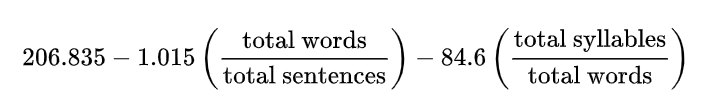  

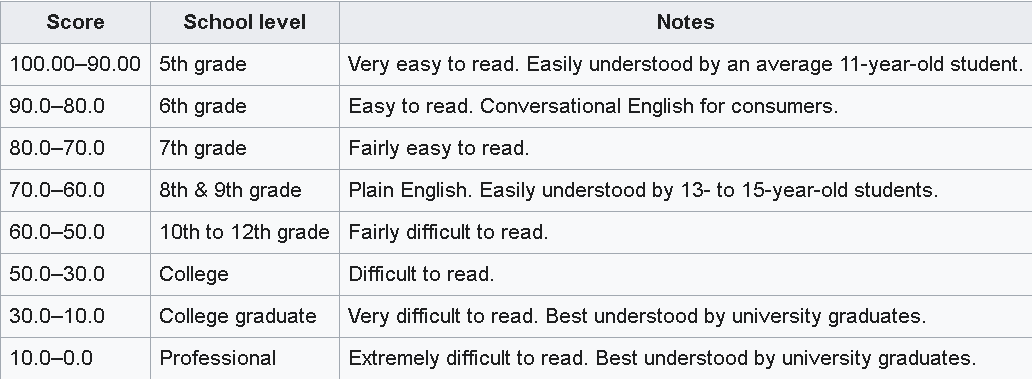
- **Flesch-Kincaid Grade:**   

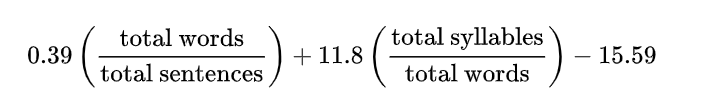  

- **Gunning Fog index:**  

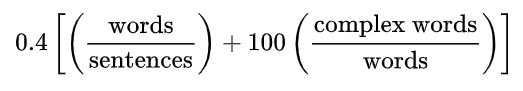     

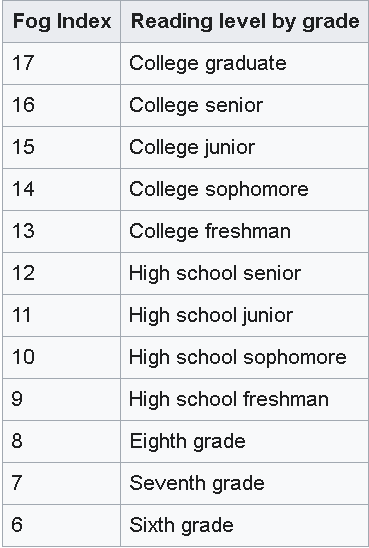

## 1. Flesch Reading Ease
We simply implement the formula with the functions defined before.

In [29]:
def flesch_reading_ease(txt):
  return 206.835 - 1.015 * (token_count(txt)/sentence_count(txt)) - 84.6 * (syl_count(txt)/token_count(txt))

for i in range(len(txt)):
    print("Text "+str(i)+" Flesch Reading Ease: "+str(flesch_reading_ease(txt[i])))

Text 0 Flesch Reading Ease: 82.49804263565892
Text 1 Flesch Reading Ease: 78.94088075880762
Text 2 Flesch Reading Ease: 55.215251798561155


As the Flesch Reading Ease's table states, the easier the text, the greater its score will be. Therefore, the first is scored as 6th grade, easy to read; the second, 7th grade, fairly easy to read; and the third, 10th/12th grade, fairly difficult to read.

## 2. Flesch-Kincaid Grade
Again, we simply copy the formula.

In [30]:
def flesch_kincaid_grade(txt):
  return 0.39 * (token_count(txt)/sentence_count(txt)) + 11.8 * (syl_count(txt)/token_count(txt)) - 15.59

for i in range(len(txt)):
    print("Text "+str(i)+" Flesch Kincaid Grade: "+str(flesch_kincaid_grade(txt[i])))

Text 0 Flesch Kincaid Grade: 3.53290697674419
Text 1 Flesch Kincaid Grade: 4.512113821138211
Text 2 Flesch Kincaid Grade: 10.490976361767732


Since this score calculates the grade of the text, we can interpret it as 3rd grade for the first text, 4th grade for the second and 10th for the last one. We can also interpret as the number of years of study a person needs to understand the text. In general, this score classified the two first texts as easier than the Flesch Reading Ease, but the last text scored in a fairly similar way using both scores.

## 3. Gunning Fog index
Once again we just need to copy the formula. Easy, right? And also fast!

In [31]:
def gunning_fog_index(txt):
  return 0.4 * ((token_count(txt)/sentence_count(txt) + 100 * (more_2_syl(txt)/token_count(txt))))

for i in range(len(txt)):
    print("Text "+str(i)+" Gunning Fog Index: "+str(gunning_fog_index(txt[i])))

Text 0 Gunning Fog Index: 4.727131782945737
Text 1 Gunning Fog Index: 6.083468834688347
Text 2 Gunning Fog Index: 12.834943473792396


We don't have number 4 in our table, but we can interpret the result for the first text to be considered as really easy (easier than 6th grade), which makes sense. The second text, just like in the first score, is classified as a 6th grade text, and the last one, High School level.

## 4. Coleman-Liau Index

In [32]:
  def letter_count(txt):
    num_words = 0
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    new_txt = ""

    for char in txt:
      if char not in punctuations:
        new_txt = new_txt + char

    for char in new_txt:
      if char == " ":
        pass
      else:  
        num_words += 1 
    return num_words
      
  def coleman_liau_index(txt):
    s = (sentence_count(txt) * (100 / token_count(txt)))
    l = (letter_count(txt) * (100 / token_count(txt)))

    return ((0.0588 * l) - (0.296 * s) - 15.8)

# Comparing the results

Below, we have a function that will help us make a side-by-side comparsion of the results.



In [33]:
def readability_scores(txt):
  print('- flesch reading ease: '+str(flesch_reading_ease(txt)))
  print('- flesch kincaid grade: '+str(flesch_kincaid_grade(txt)))
  print('- gunning fog index: '+str(gunning_fog_index(txt)))

for i in range(len(txt)):
    print('Text '+str(i))
    readability_scores(txt[i])
    print()

Text 0
- flesch reading ease: 82.49804263565892
- flesch kincaid grade: 3.53290697674419
- gunning fog index: 4.727131782945737

Text 1
- flesch reading ease: 78.94088075880762
- flesch kincaid grade: 4.512113821138211
- gunning fog index: 6.083468834688347

Text 2
- flesch reading ease: 55.215251798561155
- flesch kincaid grade: 10.490976361767732
- gunning fog index: 12.834943473792396



# Lexical diversity

Lexical Diversity measures the amount of *lexical words* in a text. Lexical words are words that aggregate meaning to a text, opposite to the *stopwords*, which only connect chunks of the text to make them grammatically correct (like *the*, *her*, *or*, etc.)

This parameter is used to determine how wide the vocabulary in a text is. However, lexical diversity by itself is not a very good indicator of the text difficulty, as this measure doesn't take into consideration the structure of the sentences in which these lexical words are used.

We use two different methods to calculate Lexical Diversity: MLTD and HDD, which can be found in [this paper](https://link.springer.com/article/10.3758/BRM.42.2.381), for readers who want to know more about them. In order to compute these values, we'll use the python library *lexical-diversity*, which already implement these functions.

## 1. MTLD

Since the words in the text need to be *lemmatized* in order to pass them as a parameter to the MLTD pre-built function, we need to use a word lemmatizer, and I chose *spacy*'s. Lemmatization, in short, is the process of regressing a word to its *root* form. Readers that are interested in learning more can find a helpful tutorial in [this link](https://stackabuse.com/python-for-nlp-tokenization-stemming-and-lemmatization-with-spacy-library/).****

In [34]:
import spacy
from lexical_diversity import lex_div as ld

def mtld(txt):
  nlp = spacy.load('en')
  doc = nlp(u""+txt)
  txt = ""
  for token in doc:
    txt += (" " + token.lemma_)
  txt = tokens_no_nums(txt)
  return ld.mtld_ma_wrap(txt)

for i in range(len(txt)):
    print("Text "+str(i)+" MLTD: "+str(mtld(txt[i])))

Text 0 MLTD: 22.857142857142858
Text 1 MLTD: 47.4375
Text 2 MLTD: 60.96992481203007


As expected, the Lexical Diversity increases as the text becomes more difficulty.

## 2. HDD
In HDD, we also need to lemmatize the text.

In [35]:
def hdd(txt):
  nlp = spacy.load('en')
  doc = nlp(u""+txt)
  txt = ""
  for token in doc:
    txt += (" " + token.lemma_)
  txt = tokens_no_nums(txt)
  return ld.hdd(txt)*100

for i in range(len(txt)):
    print("Text "+str(i)+" HDD: "+str(hdd(txt[i])))

Text 0 HDD: 65.2346630846468
Text 1 HDD: 75.41960676454342
Text 2 HDD: 79.53100450486288


Again, the LD increases with the text difficulty.

# Comparing the results
Below, we have a function so we can compare the LD more easily.

In [36]:
def lex_diversity(txt):
  print('- VOCD: '+str(hdd(txt)))
  print('- MTLD: '+str(mtld(txt)))

for i in range(len(txt)):
    print('Text '+str(i))
    lex_diversity(txt[i])
    print()

Text 0
- VOCD: 65.2346630846468
- MTLD: 22.857142857142858

Text 1
- VOCD: 75.41960676454342
- MTLD: 47.4375

Text 2
- VOCD: 79.53100450486288
- MTLD: 60.96992481203007



In [37]:
a1 = ['''These passages are selections from the First World War Diary of Robert Lindsay Mackay. Mackay was from Scotland, an American ally. He was an officer, or leader, with the 11th Battalion of the Argyll and Sutherland Highlanders from 1915 until the end of the war.

THIRD BATTLE OF YPRES. BEGUN 31ST JULY 1917
30th. July. My 21st. birthday. Champagne Dinner at night. Had to go away at 11.30 p.m. with my 50 Argyll stretcher-bearers. Got them on the move and moved up towards the 'show' which would begin in a few hours time. Another officer and 50 men of the 13th. Royal Scots now joined my party so I had 100 men. 

Got to Bivouac Camp. We were now all ready for the show. Felt things strange of course. Although I had by this time begun to dread this corner of the earth I did not feel the least bit afraid. In previous shows I had gone into action feeling that I would come out again. This time I had no such feeling. Felt, almost knew, that I would not come out again. Did not, however, leave any addresses or messages behind because I believed it unlucky….

As we marched along, I felt quite cheerful, in spite of this somewhat melancholy reflection, and would not consciously have wished myself anywhere else. Soon, I became so engrossed, that I lost every outside thought, and could only think of the present business. No regrets for the past, and no fears for the future worried me….

THE ECOLE, YPRES. 1ST. AUGUST 1917
Wed. 1st. Aug. My H.Q. are in the Ecole. The men are in a cellar, indescribably filthy, with an awful odour and three inches deep in water. Here they have to rest, sleep and eat if they can. I should be down with them but preferred risking it above ground in a tin hut (which was constantly being bombed) behind a broken down wall. A pip-squeak could have finished it and me.

I've read so many descriptions in newspapers of the ruin and desolation caused in this war. Famous literary men have tried their powers of description and all (with the possible exception of Gilbert Frankau) have failed to convey the repulsiveness and awfulness of the scene. The Ecole was one of these places - That's all!

STRETCHER BEARING
Began work at 3.15 a.m. - a cheerless hour. It was raining I think. Moved up. Searched ground up to Blue Line. Terrific rain, heavy and prolonged. Ground churned up. We could scarcely move one foot after the other. Our job was to carry down wounded. This is my first job as a bearer. I hope to goodness it is my last - prefer going over the top.

Heard about the Battalion. MacCallum killed. I'll have to write to his girl. Also Leitch and D.R.Cameron, Gray and Robinson and Sinclair wounded.

RLM War Diary - Arras (2) 1917-18
21st. …. Our casualties were 15 killed and 20 wounded, including the five officers. Very expensive this, for a day's outing. Relief completed in hopeless confusion. Back to Bn. H.Q. at 3.30 a.m. Arras at 4.45 with Stark. Bed at 6 a.m. Really tired.'''.capitalize(),
'''Think the person bullying is the big, tough kid on the playground who pushes everyone around? Could be, but it can also be the cheerleader, the student council member, or the quiet kid. A lot of times, people think that appearance defines someone who bullies, but you can’t tell who bullies just by looking at them. Students who bully can be any size, age, gender or grade.

Then what does define someone who bullies?
The answer: It’s his or her BEHAVIOR. It’s bullying when someone uses words or action to hurt or harm someone else and that person has a hard time defending himself or herself.

Sometimes kids who bully might think that it’s cool, fun or just “no big deal,” but think about it — what is cool or fun about hurting someone? Name calling, tripping someone, laughing at the person, leaving the person out, ignoring him or her on purpose—how can hurting someone possibly be “no big deal”?

If kids think about why they are bullying, they can then deal with those reasons and change their behavior. You want cool? Now that’s cool.'''.capitalize(),
'''Why is the brain so mighty? It has billions of neurons (nerve cells) to carry out its commands. Without the brain, you would not be able to think, feel, move, remember, or do all the things that make you the special person you are.

At birth, the brains of infants weigh the same. But by adulthood, that changes. The average male brain weighs about 11 to 12 percent more than a woman's brain. But brain weight and size have nothing to do with intelligence. What matters is what's inside the brain.

Despite its small size (about 3 pounds), the brain is able to receive and send an unlimited number of messages. It does this with the help of the spinal cord, the sense organs, and the autonomic (automatic) nervous system. The brain carries out this task by assigning jobs.

It puts the cerebellum (sair-ah-BELL-um) in charge of balance and coordination.
The brainstem regulates heartbeat, breathing, and blood pressure.
And the largest parts of the brain, the cerebral cortex (suh-REE-brul CORE-tex) and the cerebrum (suh-REE-brum), control thoughts, feelings, and actions.
The cerebrum is divided into two halves. Each controls the muscles on the opposite side of the body. So if you usually eat with your right hand and kick with your right foot, then your brain's left half is said to "dominate," and you're right-handed. When the opposite is true, your brain's right half takes the lead and you're left-handed.

People use both halves of the brain, but the left half is especially good at helping you with words and numbers and helping you read and speak. The right side is better at creative tasks, such as music and art. And your sense of humor develops there.

Each half has four sets of lobes (sections). The frontal lobes behind your forehead do a lot of the thinking and planning. The parietal (pa-RYE-ih-tul) lobes toward the back of your head sense pain. And the occipital (ock-SIP-ah-tul) lobes at the base of the brain allow you to see. The temporal lobes behind your ears store memories of music, taste, vision, and touch.'''.capitalize(),
'''Four kidnapped climbers face danger in a far-off country.

Four mountain climbers hung 1,000 feet above the ground. They were sleeping on tiny cots dangling from the side of a cliff.

That's when the shots rang out.

"They're shooting at us!" yelled Beth Rodden. Rodden, at age 20, was one of the world's top woman climbers.

On the ground, three soldiers waved at the climbers, yelling, "Come down, now!"

The four Americans had scaled many dangerous mountains. But nothing had prepared them for this trip.

A Foreign Land
Rodden and her boyfriend, 22-year-old Tommy Caldwell, were climbing with Jason Smith, 22, and John Dickey, 25. They were in a country called Kyrgyzstan (KURG-i-stan). It is located in central Asia.

Rebel soldiers there want to form their own country. Still, the area the climbers were in was thought to be safe.

The rebel soldiers took the climbers prisoner. The rebels hoped that they could trade the climbers for food or weapons.

Prisoners!
For days, the climbers and the rebels hiked through the mountains. Government helicopters flew overhead. The rebels hid the prisoners under sticks and dirt so that they couldn't be seen from the air.

The climbers each ate half an energy bar per day. They drank muddy water. They tried to sleep in the freezing cold.

The climbers hid as rebels traded gunfire with government soldiers. "We were terrified," Rodden said. "We knew we could die in a firefight, shot by either side.

"But," she added, "we kept talking about what we could do to escape."

A Chance for Freedom
On the sixth day, the batteries in the rebels' walkie-talkie died. The leader said he and others would return to the climbers' camp to get fresh ones. He left one man to keep the prisoners on the move.

The group crept along a cliff over a 1,500-foot drop. "[The guard] was having a hard time getting around," Smith said. "He stopped, and someone yelled, 'Now!' Then we pushed him off."

The guard's arms and legs thrashed in panic as he fell toward a river below. "I don't think anyone could survive a fall like that," Smith said. "No. Nobody could."

The climbers ran for the government's army camp. They ran for 18 miles. As they neared the camp, rebels began shooting at them. Government soldiers shot back. "We're Americans!" Smith yelled. "We're Americans!"

Moments later, the climbers were safe in the camp. Soldiers lent them clean clothes. The climbers described their ordeal.

Return to Climbing
Seven months have passed since the four Americans were captured. Today, all four are climbing again. But they also must deal with what they had to do to escape.

"It's hard to think about that," said Rodden about the guard who was pushed to his death. "But we were afraid we wouldn't survive. We'll have to live with it."'''.capitalize(),
'''Does your mood change with the seasons?

Some people find that when the temperature goes down, so do their spirits. Those people sometimes feel sad for no reason. They eat more and gain weight. They have trouble sleeping. They can't think clearly.

Here are some ways you can beat the winter blues:

Get out in the sun. Some experts say that winter blues happen because we get less sunlight in the winter than we do in other seasons. Some say that the decrease in sunlight can make us feel sad. Getting extra sunlight each day can help brighten your mood.
Get some exercise. A brisk walk or other exercise will make chemicals called endorphins flow through your body. Endorphins are natural "feel good" chemicals.
Eat more healthful foods. Avoid having too much sugar. If you crave sugary foods (like cookies or candy), it may be a sign that you need more protein (like meat, chicken, or fish).
Avoid holiday stress. Cut back if you have too many things to do. Make sure you have some quiet time to yourself. Get some rest. Don't be so busy that you get run-down. Studies show that most teens need about nine hours of sleep each night. The average teen, though, gets only about six or seven hours of sleep per night.
Get help. If you feel sad all the time and the feeling won't go away, you may have a bigger problem than the winter blues. Talk to an adult you trust. Get help from a doctor.'''.capitalize(),
'''Going along with the crowd doesn’t have to be a risky move.

Ever done something you didn’t want to do, just to fit in? Or just because your friends wanted you to? That’s peer pressure. And just about everyone feels it at one time or another.

Peers are people your age, such as your friends, who have experiences similar to yours. Your peers influence your decisions and behavior every day, and they can push you to make bad choices, even dangerous ones. But is peer pressure always bad?

Positive Spin on Peer Pressure

“Peer pressure can sometimes be a good thing,” says Ian Brennan, cocreator and one of the writers of the TV show Glee. That show dealt with the issue of peer pressure all the time, through the experiences of musical kids in a not-so-popular high school chorus. “Friends can give you the courage to try something you normally wouldn’t, like a new sport or auditioning for the school play,” Brennan points out.

Nicole S., 16, of Edmore, N.D., used to be afraid of singing in front of people. One time, her friends convinced her to sing karaoke with them. She ended up having fun! “Now I will sing anywhere, even with people present. Positive peer pressure helped me face my fear,” she says.

Pressure’s On!

You are surrounded by your peers all the time, and you learn a lot—both good and bad—by just being around them. You might admire a star athlete. Maybe you notice the popular kids at school and look up to them. Those aren’t necessarily bad things. The popular group could be really nice; the athlete, a hard worker. Being inspired and influenced by different peer groups could help you in the long run.

The people around you can also be negative influences, however. Maybe a star teammate tells you never to pass the ball to a certain player, or a popular student cheats on tests or sends mean texts. Should you try to be like them to fit in?

Peer Pressure Is a Fact of Life

“It’s not a matter of if peer pressure is going to happen,” says Lee Erickson, coordinator for the Northern Lights Students Against Destructive Decisions (SADD) group in North Dakota. “It’s a matter of when.”

“The main thing is not to compromise who you are,” Erickson continues. “The kind of coolness and popularity you think you may get by joining the crowd and doing risky stuff is temporary. Your character is with you for the rest of your life.”

Nicole agrees. “My motto is be who you are, not who others want you to be,” she says.

Peer pressure is powerful, but the ability to choose is yours. If a situation feels wrong, there’s a good chance it is wrong. Think about what’s best for you—and what you’ll say or do—before you’re in a sticky situation. “No one has tried to get me to smoke or drink yet, but I know there will come a time,” says Schuyler W., 13, of Seattle. “The thing is, I know I don’t want to do it, so when it does happen, I’m just going to stick up for myself and say no.”

Make pacts with your friends to stay away from risky situations together and to support one another when the going gets tough. Talk with your parents about ways they can “bail you out” if you need to save face with your peers. (For instance, if someone asks you to hang out after school and you think there might be drinking or drugs around, you can tell them your parents need you to come home right away.)

Should You or Shouldn’t You?

Standing up for yourself and saying no isn’t always easy. But you might give voice to a bunch of peers that feel the same way you do. It can take just one person to speak out and change a situation. According to Erickson, “People will respect you for standing up for yourself—even if it doesn’t seem like it right away.”

“If friends try to get you to do something that you know in your heart feels wrong,” says Glee’s Brennan, “tell them exactly how you feel. And if they’re not cool about it, find new friends.”

That can be hard to do, but sometimes it’s necessary. “If your so-called friends are trying to get you to do negative things, do you really think they’re the best of friends?” asks Nicole. “To me, real friends accept you for who you are [and] what you believe in, and respect your decisions.”

Bad News and Good News

“Negative peer pressure gets ahold of us kids really easily,” says Nicole. “Because our friends do it, we’re told something’s ‘cool’ or we’re pressured to try something ‘just one time’ because it won’t hurt.”

Some kids decide to go with the flow regardless of what they know is right. They tell themselves that being popular or being liked is more important than their own sense of self. It doesn’t make sense, but that’s the problem with peer pressure. You can lose yourself. But you can also find yourself, as Schuyler did when he was asked to go camping last year. He really didn’t want to go.

“Sometimes your friends get you to do stuff you don’t want to do, and it turns out great,” he says. “I didn’t want to go camping, but my friends really wanted me to go. Finally, I gave in, and I’m so glad I did. The trip was awesome! We did a lot of fun stuff I would never have done on my own.”

The good news is peer pressure isn’t always something to fear. Your decisions are yours to make. Take the time to make them wisely.

Power Up

Resisting negative peer pressure is a challenge, but it is definitely possible. Here are a few tips for navigating all kinds of pressure-filled situations:

Find real friends who accept the real you. Knowing whom to listen to and whom to avoid is the key to steering clear of negative peer pressure.
Know what to say. “Just say doing that stuff really isn’t your thing,” says Elli L., 15, of North Dakota. “You can also blame your parents—it works wonders.”
Be confident. Stick up for yourself. People will respect you for it.
Think about it. Keep in mind that just one destructive decision can change your whole life, says Nicole S., 16, also of North Dakota. Think: How might this one moment affect how you see yourself?
Getting Real With SADD

Looking to join other kids who want to make smart decisions and avoid negative peer pressure? Check out Students Against Destructive Decisions (SADD). It’s a national group, based in middle schools and high schools, that works to save lives by spreading the word about the dangers of risky behaviors such as drinking, using tobacco, bullying, and driving distractedly (including driving while using a cell phone).

SADD is a great resource for kids who are feeling pressured. “It is comforting to know that there are so many people supporting each other,” says Elli L., a SADD member in North Dakota. “We all kind of hold each other up.”'''.capitalize(),
'''Austria-Hungary felt its power slipping after the Archduke’s assassination. It wanted to assert itself and try to regain control. Austria-Hungary prepared to take action against Serbia. First, however, Austria-Hungary went to seek help and support from its neighbor Germany. Germany assured Austria-Hungary that the German government would support any Austro-Hungarian action against Serbia. On July 28, 1914, Austria-Hungary declared war on Serbia. World War I began.
As Germany supported Austria-Hungary, Russia supported Serbia. As soon as Austria-Hungary declared war, Russia started preparing troops for battle.
Germany took Russia’s preparation as an act of war against Austria-Hungary. Germany declared war on Russia.
France was tied to Russia by a separate treaty. France declared war on Germany to keep its promise to Russia. 
In response to France’s declaration of war, Germany invaded a neutral country, Belgium. Belgium was close to France and Germany wanted to take over France. 
Britain was bound by a treaty to France and Belgium. Britain declared war on Germany.
In 1914 Britain was still an empire. All of Britain’s territories overseas entered the war on Britain’s side. Their entrance extended the war beyond the boundaries of Europe. Australia, Canada, India, New Zealand, and the Union of South Africa joined the fighting.
Japan had military ties to Britain. Soon Japan declared war on Germany.  In response, Austria-Hungary declared war on Japan.
The United States declared that it would remain neutral. However, this policy of neutrality could not last forever.'''.capitalize(),
'''When plates in the earth spread apart, molten lava comes up from the planet’s inner layers. It then spits out of the mouth of the volcano. Lava is very hot. It is 10 times as hot as boiling water. If you stand too close to flowing lava, your eyelashes and eyebrows will instantly burn off.

Lava spews out of a volcano. Sometimes it shoots high up into the air. Lava rivers quickly form and travel down the sides of the volcano. They are a grave danger to those who live on or around the volcano. Lava sets trees and houses on fire. If the flow is fast, people can die if they don’t get out of the way in time.

Kilauea is a special volcano because it is on what used to be a small island. As lava rivers run into the ocean, it cools, hardens, and becomes earth, expanding the size of the island. In fact, all Hawaiian Islands were formed from the eruption of volcanoes.'''.capitalize(),
'''The first thing I do every morning, before I stretch or get out of bed, is rub my eyes three times with closed fists. Then I get out of bed and tap my right big toe on the floor three times before walking to the bathroom to brush my teeth.

It’s not that I enjoy the odd habits or anything. I’m just used to them, and they’re kind of a part of me. As I brush my teeth, I look at myself in the mirror. I like to inventory things about me that relate to my family. I have light green eyes and thick eyebrows like my dad’s, a short nose like my mom’s, and a ton of freckles, like my older brother Joey. If you look at my face closely, you will see that I am really not my own person. I’m just someone made up of the different parts of everyone else in my family.

My friend Susanna says that’s kind of a morbid way of thinking about my life, but I don’t think she knows the correct way to use the word “morbid.”

After I’m done brushing my teeth, I walk back to my bedroom, toe-to-heel, very slowly. Then I get dressed for school. We have to wear a uniform, so I wear the same thing every day: a blue and green plaid skirt with a navy blue polo shirt and black loafers. Susanna finds the uniform boring (she says it infringes on her self-identity), but I don’t mind it so much. It’s just one less thing I have to worry about in the morning.

I eat the same thing for breakfast every day: oatmeal with bananas and a few spoonfuls of brown sugar. My mom prepares breakfast for Joey and me because our dad has usually already left for work by the time we’re ready for breakfast.

Joey sits at the head of the table, and I sit at the foot of the table. He always reads the sports section of the newspaper, and I always get the front page.

On the way to school, I buckle and unbuckle the seat belt two times. My mom doesn’t ever say anything, but my habit seems to really annoy Joey.

“Rose, stop it!” he says, turning around to glare at me from the front seat.

“Just ignore it!” I respond, and click once more.

“Settle down, settle down,” Mom says.

We are all quiet on the rest of the way to school. My mom says it takes her a while to wake up in the morning; otherwise she’d be chattier. I don’t mind though. It’s sometimes nice just to watch the streets go by out the car window, with the people walking along the sidewalks. We always listen to the same radio show, “The Darnell Owens Show,” whose emcees talk about movies. They especially love film noir.

When we get to school, Joey slams the door behind him, and I reach between the front seats to give my mom a kiss good-bye.

In school, I meet Susanna by our lockers. They’re right next to each other in a prime spot by our classroom, because Susanna complained to the principal that she didn’t feel comfortable “expressing herself” on the inside of her locker next to any other person in our grade. (Susanna’s dad is a lawyer, and her mom is an artist.)

I open and close the locker three times before I reach inside to grab my books for social studies and math.

Susanna is chattering on about this new painting she and her mom did in her mom’s studio when the long shadow of William Jones crosses over us.

“Hey, freaks,” he says.

Susanna and I glance at each other.

“What do you want, William?” Susanna says defiantly.

I’m always in such awe of her bravery. William started making fun of us when we were in first grade. That’s when my habit really picked up, and he noticed that I was tapping the doorway three times every time we left the classroom or sneezing three times, even when I didn’t have to. Well, Susanna started sticking up for me, which is how we became such great friends, but it only made things worse with William. Soon William started mimicking Susanna when she raised her hand to answer a question (which she did often), and mocking the way she walked, always with one hand on her hip.

“Just wanted to say good morning. Just wanted to say good morning. Just wanted to say good morning,” he says, smiling and curling his lip. “Three times… Right, loser?”

I shake my head and turn back to my locker, like what he says doesn’t hurt my feelings. I can’t help my habit—it just pops up when I least expect it. My mom says the people who make fun of me are ignorant, but she still takes me to see Dr. P. every week to try to help me get over my habit.

“Doesn’t it get old?” Susanna asks.

“Nope!” William bares his teeth at us and then walks into the classroom.

“Just forget him,” Susanna says, patting me on the back. I’m glad Susanna is on my side.

Joey and I take the bus home together after school. At the bus stop, Joey always gets off first. He’s supposed to wait for me to get off the bus before starting to walk home, but he rarely does. I end up walking a few yards behind him, watching his dirty backpack move up and down as he moves.

Mom has a snack waiting for us when we get home—carrots and ranch dressing—and every day we have to eat it and then do our homework right away. Joey says he does his homework in his room, but he’s just playing video games. Mom lets him get away with it.

I sit down at the kitchen table and pull my worksheets out of my backpack to start in on my math homework. Mom sits next to me, takes a carrot out of the plastic dish, and dips it in ranch.

“How was school?”

“It was okay. William was teasing me again.” Mom looks sad when I say this.

“I’m sorry, sweetie. Things will get better,” she says.

“I know,” I say. I do my homework and then go read in my room until it’s time for dinner.

I wonder if I will ever “kick my habit,” as Dr. P. likes to say. Dr. P. thinks that my habit is something I can train myself to give up. She thinks that with a little bit of effort on my part and with lots of help from her, I can learn not to need my habit to feel comfortable. Most of the time, I believe her and even want to kick my habit. Maybe then, Joey wouldn’t be embarrassed of me, and William wouldn’t tease me. But without my habit, I don’t think that Susanna and I would have become friends. I also don’t think that I’d feel the same sense of happiness I feel when I touch things or do things three times. There’s something very back and forth about my relationship to my habit—I’m not sure I’m ready to give it up. Maybe someday in the future.

“Rose, dinner!” Mom calls.

I go to the bathroom, look at my face in the mirror, and wash my hands three times before going downstairs to eat.'''.capitalize(),
'''You’ve probably seen pictures, models, or movies about dinosaurs that lived millions of years ago. But how do we know so much about these animals? How do we know what they looked like and how they lived? Since the early 1800s, scientists have been piecing together this mystery with fossils.

Fossils are the remains of ancient life that are usually buried in rock. Most fossils formed from the hard parts of organisms such as teeth, shells, and bones. They also form from things a plant or animal leaves behind, like a footprint, a leaf print, and even eggs. Fossils show us what Earth was like long ago. They give us a picture of ancient environments. Scientists compare fossils from different time periods to investigate how life on Earth has changed over time.'''.capitalize()]

In [38]:
import statistics

def flesch_reading_ease_vote(txt):
  resp = flesch_reading_ease(txt)
  if resp >= 90:
    return 0
  elif resp < 90 and resp >= 80:
    return 1
  elif resp < 80 and resp >= 70:
    return 2
  elif resp < 70 and resp >= 60:
    return 3
  elif resp < 60 and resp >= 50:
    return 4
  elif resp < 50 and resp >= 30:
    return 5
  else:
    return 6

def flesch_kincaid_grade_vote(txt):
  resp = flesch_kincaid_grade(txt)
  if resp <= 5.0:
    return 0
  elif resp > 5.0 and resp <= 6.0:
    return 1
  elif resp > 6.0 and resp <= 7.0:
    return 2
  elif resp > 7.0 and resp <= 9.0:
    return 3
  elif resp > 9.0 and resp <= 12.0:
    return 4
  elif resp > 12.0 and resp <= 16.0:
    return 5
  else:
    return 6

def gunning_fog_index_vote(txt):
  resp = gunning_fog_index(txt)
  if resp <= 6.0:
    return 0
  elif resp > 6.0 and resp <= 7.0:
    return 1
  elif resp > 7.0 and resp <= 8.0:
    return 2
  elif resp > 8.0 and resp <= 10.0:
    return 3
  elif resp > 10.0 and resp <= 13.0:
    return 4
  elif resp > 13.0 and resp <= 17.0:
    return 5
  else:
    return 6

def coleman_liau_index_vote(txt):
  resp = coleman_liau_index(txt)
  if resp <= 5.0:
    return 0
  elif resp > 5.0 and resp <= 6.0:
    return 1
  elif resp > 6.0 and resp <= 7.0:
    return 2
  elif resp > 7.0 and resp <= 10.0:
    return 3
  elif resp > 10.0 and resp <= 12.0:
    return 4
  elif resp > 12.0 and resp <= 16.0:
    return 5
  else:
    return 6

#media sem arredondar

def vote_mean(txt):
  results = [flesch_kincaid_grade_vote(txt), gunning_fog_index_vote(txt), coleman_liau_index_vote(txt)]
  return statistics.mean(results)

def vote_mode(txt):
  results = [flesch_reading_ease_vote(txt), flesch_kincaid_grade_vote(txt), gunning_fog_index_vote(txt),coleman_liau_index_vote(txt)]
  try:
    return statistics.mode(results)
  except:
    return results[0]

def vote_median(txt):
  results = [flesch_reading_ease_vote(txt), flesch_kincaid_grade_vote(txt), gunning_fog_index_vote(txt),coleman_liau_index_vote(txt)]
  return statistics.median(results)

def vote_decode(n):
  if n <= 0:
    return "A1"
  elif n == 1:
    return "A2"
  elif n == 2:
    return "B1"
  elif n == 3:
    return "B2"
  elif n == 4:
    return "C1"
  elif n == 5:
    return "C2"
  else:
    return "Fluent"

In [70]:
import math
from collections import Counter

def accuracy(txt, expected_level, vote, round):
  raw_votes = []
  for t in txt:
    if vote == "mode":
      raw_votes.append(vote_mode(t))
    elif vote == "mean":
      raw_votes.append(vote_mean(t))
    else:
      raw_votes.append(vote_median(t))
  
  round_votes = []
  for v in raw_votes:
    if round == "ceil":
      round_votes.append(math.ceil(v))
    else:
      round_votes.append(math.floor(v))
  
  results = []
  levels = []
  for v in round_votes:
    r = vote_decode(v)
    results.append(r == expected_level)
    levels.append(r)
  
  return sum(results)/len(results), Counter(levels)

def test_techniques(txt):
  print('**********************')
  print('Votes')
  print('**********************')
  print()
  print('Flesch reading ease votes:')
  print(vote_decode(flesch_reading_ease_vote(txt))+': '+str(flesch_reading_ease(txt)))
  print()
  print('Flesch kincaid grade votes:')
  print(vote_decode(flesch_kincaid_grade_vote(txt))+': '+str(flesch_kincaid_grade(txt)))
  print()
  print('Gunning Fog index votes:')
  print(vote_decode(gunning_fog_index_vote(txt))+': '+str(gunning_fog_index(txt)))
  print()
  print('Coleman Liau Index votes:')
  print(vote_decode(coleman_liau_index_vote(txt))+': '+str(coleman_liau_index(txt)))
  print()
  print()

In [40]:
print("Mean/floor:" + str(accuracy(txt, "A1", "mean", "floor")))
print("Mean/ceil:" + str(accuracy(txt, "A1", "mean", "ceil")))

print("Mode/floor:" + str(accuracy(txt, "A1", "mode", "floor")))
print("Mode/ceil:" + str(accuracy(txt, "A1", "mode", "ceil")))

print("Median/floor:" + str(accuracy(txt, "A1", "median", "floor")))
print("Median/ceil:" + str(accuracy(txt, "A1", "median", "ceil")))

Mean/floor:(0.3333333333333333, Counter({'A1': 1, 'A2': 1, 'C1': 1}))
Mean/ceil:(0.0, Counter({'A2': 1, 'B1': 1, 'C1': 1}))
Mode/floor:(0.0, Counter({'A2': 1, 'B1': 1, 'C1': 1}))
Mode/ceil:(0.0, Counter({'A2': 1, 'B1': 1, 'C1': 1}))
Median/floor:(0.3333333333333333, Counter({'A1': 1, 'A2': 1, 'C1': 1}))
Median/ceil:(0.0, Counter({'A2': 1, 'B1': 1, 'C1': 1}))


## Testing text levels

In [75]:
txt = '''
Is this the real life?
Is this just fantasy?
Caught in a landslide
No escape from reality
Open your eyes
Look up to the skies and see
I'm just a poor boy, I need no sympathy
Because I'm easy come, easy go
A little high, little low
Anyway the wind blows, doesn't really matter to me, to me
Mama, just killed a man
Put a gun against his head
Pulled my trigger, now he's dead
Mama, life had just begun
But now I've gone and thrown it all away
Mama, ooo
Didn't mean to make you cry
If I'm not back again this time tomorrow
Carry on, carry on, as if nothing really matters
Too late, my time has come
Sends shivers down my spine
Body's aching all the time
Goodbye everybody - I've got to go
Gotta leave you all behind and face the truth
Mama, ooo - (anyway the wind blows)
I don't want to die
I sometimes wish I'd never been born at all
I see a little silhouetto of a man
Scaramouch, scaramouch will you do the fandango
Thunderbolt and lightning - very very frightening me
Gallileo, Gallileo,
Gallileo, Gallileo,
Gallileo Figaro - magnifico
But I'm just a poor boy and nobody loves me
He's just a poor boy from a poor family
Spare him his life from this monstrosity
Easy come easy go - will you let me go
Bismillah! No - we will not let you go - let him go
Bismillah! We will not let you go - let him go
Bismillah! We will not let you go - let me go
Will not let you go - let me go (never)
Never let you go - let me go
Never let me go - ooo
No, no, no, no, no, no, no -
Oh mama mia, mama mia, mama mia let me go
Beelzebub has a devil put aside for me
For me
For me
So you think you can stone me and spit in my eye
So you think you can love me and leave me to die
Oh baby - can't do this to me baby
Just gotta get out - just gotta get right outta here
Ooh yeah, ooh yeah
Nothing really matters
Anyone can see
Nothing really matters - nothing really matters to me
Anyway the wind blows...
'''.capitalize()

In [ ]:
#@title
kids_songs = ['''Ohhhh, a pirate's life
Is the life for me
I love to sail
The deep blue sea
The whole Spanish main
Won't ever be the same
I'll be the best
Of the pirate kings!

Ohhhh, a jolly roger
Is what I need
My crew will follow
Where I lead
We are rough, we are tough
And we really know our stuff
A pirate's life
Is the life for me

Ohhhh, the plank is walked
Most every day
A pirate needs
His time to play
We huff and we puff
Won't ever have enough
A pirate's life
Is the life for me

We're searchin' for
A treasure chest
The gold and silver
We like best
Doubloons everywhere
There's danger in the air
A pirate's life
Is the life for me

Ohhhh, a pirate's life
Is the life for me
I love to sail
The deep blue sea
The whole Spanish main
Won't ever be the same
A pirate's life
Is the life for me
The whole Spanish main
Won't ever be the same
A pirate's life
Is the life for me'''.capitalize(),

'''
You can tell the world
You never were my girl
You can just forget me
When I’m gone
Or you can tell your friends
Just what a fool I’ve been
And laugh and joke on the phone
You can tell my arms
Go back to the farm
You can tell my feet
To hit the floor
Or you can tell my lips
To tell my fingertips
They won’t be reaching out
No more

But don’t tell my heart
My achy breaky heart
I just don’t think he’d understand
And if you tell my heart
My achy breaky heart
I might break down and cry today
Oooo

You can tell my Ma
I moved to Arkansas
You can tell your dog
I’m gone for good
Or you can tell your brother Cliff
I’ve given him the slip
He never really liked me anyway
Or you can tell your Aunt Louise,
Tell anyone you please,
Myself already knows I’m not okay
Or you can tell my eyes
To watch out for my mind
It might be walking out on me today
'''.capitalize(),
'''
They're gonna put me in the movies
They're gonna make a big star
Out of me
We'll make a film about a man
That's sad and lonely
And all I got to do is
Act naturally

We'll make this scene about a man
That's sad and lonely
Begging down upon his bended knee
I'll play the part
And I won't need rehearsin'
All I have to do is
Act naturally

Well I bet you
I'm gonna be a big star
Might win an Oscar
You can never tell
The movie's gonna make me a big star
Cause I can play the part
So well

I hope you'll come and see me
In the movie
Then I'll know that you will
Plainly see
The biggest fool that ever hit
The big time
And all I got to do is
Act naturally
'''.capitalize(),
'''
We are the Biggles and we love you
Oh, we are the Biggles, do you love us, too?
Oh, we'll make you giggle your cares away
Come on it's time for us to play

We are your magic secret friends
And on us you can depend
Biggles can be big or small
And we'll bring you here when you call

Let us take you by the hand
It's adventure time in Biggleland
Keep us a secret if you can
Oh, oh

We love the Biggles, yes we do
Oh, we love the Biggles, you will too
Oh, they make us giggle our cares away
Come on it's time for us to play

My name is Ruby and I love fun
My brother Billy's the silly one
Little Freckles lives next door
So many places to explore

Let us take you by the hand
It's adventure time in Biggleland
Keep us a secret if you can
Oh, oh

We are the Biggles, and we love you
Oh, we are the Biggles, do you love us, too?
Oh, we're gonna giggle our cares away
Come on it's time for us to play
'''.capitalize(),
'''
Come on and hear
Come on and hear
Alexander’s Ragtime Band
Come on and hear
Come on and hear
It’s the best band in the land
They can play a bugle call
Like you’ve never heard before
So natural that you want to hear some more
That’s just the bestest band what am
Honey lamb

Come on along
Come on along
Let me take you by the hand
Up to the man
Up to the man
Who’s the leader of the band
And if you care to hear the "The Swanee River"
Played in Ragtime
Come on and hear
Come on and hear
Alexander’s Ragtime Band

Come on and hear
Come on and hear
Alexander’s Ragtime Band
Come on and hear
Come on and hear
It’s the best band in the land
They can play a bugle call
Like you’ve never heard before
So natural that you want to hear some more
That’s just the bestest band what am
Honey lamb

Come on along
Come on along
Let me take you by the hand
Up to the man
Up to the man
Who’s the leader of the band

And if you care to hear "The Swanee River"
Played in Ragtime
Come on and hear
Come on and hear
Alexander’s Ragtime Band
'''.capitalize(),
'''
Daisy, Daisy, give me your answer true
I’m half crazy over the love of you
It won’t be a stylish marriage
I can’t afford a carriage
But you’ll look sweet
Upon the seat
Of a bicycle built for two

Ruby, Ruby, give me your answer true
Will you let me peddle along with you
When you and I go cruisin’
You’ll thank me for choosin’
You to come and have some fun
On a bicycle built for two

Billy, Billy, give me your answer true
I love riding, do you love it too
Slow or fast or faster
You lead, I’ll follow after
The path flies by as you and I
Ride a bicycle built for two

A bicycle built for two
'''.capitalize(),
'''
Down by the bay
Where the watermelons grow
Back to my home
I dare not go
For if I do
My mother will say
Did you ever see a baboon
Holding a balloon
Down by the bay
Where the watermelons grow
Back to my home
I dare not go
For if I do
My mother will say
Did you ever see a baboon
Holding a balloon
Did you ever see a whale
With a polka-dot tail
Down by the bay
Where the watermelons grow
Back to my home
I dare not go
For if I do
My mother will say
Did you ever see a baboon
Holding a balloon
Did you ever see a pig
Wearing a wig
Down by the bay
Where the watermelons grow
Back to my home
I dare not go
For if I do
My mother will say
Did you ever see a baboon
Holding a balloon
Did you ever see a goat
Standing in a boat
Down by the bay
Where the watermelons grow
Back to my home
I dare not go
For if I do
My mother will say
Did you ever see a baboon
Holding a balloon
Did you ever see a llama
Wearing pajamas
'''.capitalize(),
'''
Found a peanut
Found a peanut
Found a peanut last night
Last night I found a peanut
Found a peanut last night
Cracked it open
Cracked it open
Cracked it open last night
Last night I cracked it open
Cracked it open last night
'''.capitalize(),
'''
Five little monkeys jumping on the bed
One fell off and bumped his head
Mama called the doctor,
And the doctor said
No more monkeys jumping on the bed

Four little monkeys jumping on the bed
One fell off and bumped his head
Mama called the doctor
And the doctor said,
No more monkeys jumping on the bed

Three little monkeys jumping on the bed
One fell off and bumped his head
Mama called the doctor
And the doctor said,
No more monkeys jumping on the bed

Two little monkeys jumping on the bed
One fell off and bumped his head
Mama called the doctor
And the doctor said,
No more monkeys jumping on the bed

One little monkey jumping on the bed
One fell off and bumped his head
Mama called the doctor
And the doctor said,
Put those monkeys right to bed
'''.capitalize(),
'''
Some think
The world is made for fun and frolic
And so do I
And so do I
Some think
It well to be all melancholic
To pine and sigh
To pine and sigh

But I
I love to spend my time in singing
Some joyous song
Some joyous song
To set
The air with music bravely ringing
Is far from wrong
Is far from wrong

Listen, listen
Music sounds so fun
Listen, listen
Music sounds so fun
Tra la la la
Tra la la la
Tra la la la
Tra la la la
Music sounds so fun

Tra la la la
Tra la la la

But I
I love to spend my time in singing
Some joyous song
Some joyous song
To set
The air with music bravely ringing
Is far from wrong
Is far from wrong

Listen, listen
Music sounds so fun
Listen, listen
Music sounds so fun
Tra la la la
Tra la la la
Tra la la la
Tra la la la
Music sounds so fun
Tra la la la
Tra la la la
Music sounds so fun
Tra la la la
Tra la la la
'''.capitalize()
]

In [76]:
test_techniques(txt)

**********************
Votes
**********************

Flesch reading ease votes:
C2: 30.184365605658712

Flesch kincaid grade votes:
Fluent: 24.658766578249345

Gunning Fog index votes:
Fluent: 28.21025641025641

Coleman Liau Index votes:
B1: 6.812201591511936




In [ ]:
#@title
disney_songs = [
'''
I can show you the world
Shining, shimmering, splendid.
Tell me, princess, now when did
You last let your heart decide.

I can open your eyes,
Take you wonder by wonder,
Over, sideways and under
On a magic carpet ride.

A whole new world,
A new fantastic point of view.
No one to tell us no
Or where to go
Or say we're only dreaming.

A whole new world
A dazzling place I never knew
But now from way up here
It's crystal clear
That now I'm in a whole new world with you

Now I'm in a whole new world with you

Unbelievable sights
Indescribable feeling
Soaring, tumbling, freewheeling
Through an endless diamond sky

A whole new world

Don't you dare close your eyes

A hundred thousand things to see

Hold your breath; it gets better

I'm like a shooting star
I've come so far
I can't go back to where I used to be

A whole new world

Every turn a surprise

With new horizons to pursue

Every moment red-letter

I'll chase them anywhere
There's time to spare
Let me share this whole new world with you

A whole new world

A whole new world

That's where we'll be

That's where we'll be

A thrilling chase

A wondrous place

For you and me
'''.capitalize(),
'''
I can see what's happening
What?
And they don't have a clue!
Who?
They'll fall in love and here's the bottom line
Our trio's down to two
Oh
The sweet caress of twilight
There's magic everywhere
And with all this romantic atmosphere
Disaster's in the air

Can you feel the love tonight?
The peace the evening brings
The world, for once, in perfect harmony
With all its living things

So many things to tell her
But how to make her see
The truth about my past?
Impossible!
She'd turn away from me

He's holding back, he's hiding
But what, I can't decide
Why won't he be the king I know he is
The king I see inside?

Can you feel the love tonight?
The peace the evening brings
The world, for once, in perfect harmony
With all its living things

Can you feel the love tonight?
You needn't look too far
Stealing through the night's uncertainties
Love is where they are

And if he falls in love tonight
It can be assumed
His carefree days with us are history
[Timon & Pumbaa:] In short, our pal is doomed
'''.capitalize(),
'''
Hakuna Matata
What a wonderful phrase
Hakuna Matata
Ain't no passing craze
It means no worries
For the rest of your days
[Timon & Pumbaa:] It's our problem-free philosophy
Hakuna Matata

When he was a young warthog
When I was a young warthog
He found his aroma lacked a certain appeal
He could clear the savannah after every meal
I'm a sensitive soul though I seem thick-skinned
And it hurt that my friends never stood downwind

And, oh, the shame!
He was ashamed!
Thought of changin' my name
Oh, what's in a name?
And I got downhearted
How'd you feel?
Every time that I -
Hey, Pumbaa, not in front of the kids
Oh, sorry

[Timon & Pumbaa:] Hakuna Matata
What a wonderful phrase
Hakuna Matata
Ain't no passing craze
It means no worries
For the rest of your days
[Simba & Timon:] It's our problem-free
Philosophy
Hakuna Matata

Hakuna Matata
Hakuna Matata
Hakuna Matata
Hakuna -
It means no worries
For the rest of your days
It's our problem-free philosophy
Hakuna Matata
Hakuna Matata
Hakuna Matata
Hakuuuuuuna Matata
Hakuna Matata
Hakuna Matata
Hakuuuuna Matata
Hakuna Matata
'''.capitalize(),
'''
I'm gonna be a mighty king
So enemies beware!

Well, I've never seen a king of beasts
With quite so little hair!

I'm gonna be the main event
Like no king was before
I'm brushing up on looking down
I'm working on my roar!

Thus far, a rather uninspiring thing

Oh, I just can't wait to be king!

No one saying do this

No one saying be there

No one saying stop that!

No one saying see here

Free to run around all day
Free to do it all my way!

I think it's time that you and I
Arranged a heart to heart

Kings don't need advice
From little hornbills for a start

If this is where the monarchy is headed
Count me out
Out of service, out of Africa
I wouldn't hang about!
This child is getting wildly out of wing

Oh, I just can't wait to be king!

Everybody look left
Everybody look right
Everywhere you look I'm
Standing in the spotlight

Not yet!

Let every creature go for broke and sing
Let's hear it in the herd and on the wing
It's gonna be King Simba's finest fling

Oh, I just can't wait to be king!
Oh, I just can't wait to be king!
Oh, I just can't wait to be king!
'''.capitalize(),
'''
From the day we arrive on the planet
And blinking, step into the sun
There's more to see than can ever be seen
More to do than can ever be done

There's far too much to take in here
More to find than can ever be found
But the sun rolling high
Through the sapphire sky
Keeps great and small on the endless round

It's the circle of life
And it moves us all
Through despair and hope
Through faith and love
Till we find our place
On the path unwinding
In the circle
The circle of life

It's the circle of life
And it moves us all
Through despair and hope
Through faith and love
Till we find our place
On the path unwinding
In the circle
The circle of life
'''.capitalize(),
'''
I've been standing at the edge of the water
Long as I can remember
Never really knowing why
I wish I could be the perfect daughter
But I come back to the water
No matter how hard I try

Every turn I take
Every trail I track
Every path I make
Every road leads back to the place I know
Where I cannot go
Where I long to be

See the line where the sky meets the sea
It calls me
No one knows how far it goes
If the wind in my sail on the sea stays behind me
One day I'll know
If I go there's just no telling how far I'll go

I know everybody on this island
Seems so happy on this island
Everything is by design
I know everybody on this island
Has a role on this island
So maybe I can roll with mine

I can lead with pride
I can make us strong
I'll be satisfied if I play along
But the voice inside sings a different song
What is wrong with me

See the light as it shines on the sea
It's blinding
But no one knows how deep it goes
And it seems like it's calling out to me
So come find me
And let me know
What's beyond that line
Will I cross that line

See the line where the sky meets the sea
It calls me
And no one knows how far it goes
If the wind in my sail on the sea stays behind me
One day I'll know
How far I'll go
'''.capitalize(),
'''
Moana, make way, make way!
Moana, it's time you knew
The village of Motunui is
All you need

The dancers are practising
They dance to an ancient song
his old one's all we need)

This tradition is our mission
And Moana, there's so much to do
(Make way!)
Don't trip on the taro root
That's all you need

We share everything we make
(We makea!)
The fishermen come back from the sea

I wanna see

Don't walk away
Moana, stay on the ground now
Our people will need a chief
And there you are

There comes a day
When you're gonna look around
And realize happiness is
Where you are

Consider the coconut
Consider its tree
We use each part of the coconut
That's all we need

We make our nets from the fibers
(We make our nets from the fiberse water is sweet inside use the leaves to build fires cook up the meat inside)

Consider the coconuts
(Consider the coconuts!)
The island gives us what we need

And no one leaves

That's right, we stay
We're safe and we're well provided
And when we look to the future
There you are

You'll be okay
In time you'll learn just as I did
You must find happiness right
Where you are

I like to dance with the water
The undertow and the waves
The water is mischievous
Ha! I like how it misbehaves

The village may think I'm crazy
Or say that I drift too far
But once you know what you like, well
There you are

You are your father's daughter
Stubbornness and pride
Mind what he says but remember
You may hear a voice inside
And if the voice starts to whisper
To follow the farthest star
Moana, that voice inside is
Who you are

We make our nets from the fibers
(We weave our nets from the fibersreal tasty treat inside sing these songs in our choir have mouths to feed inside)

The village believes in us
(That's right!!)
The island gives us what we need
And no one leaves

So here I'll stay
My home, my people beside me
And when I think of tomorrow
There we are

I'll lead the way
I'll have my people to guide me
We'll build our future together
Where we are

'Cause every path leads you back to
Where you are
You can find happiness right
Where you are
Where you are
'''.capitalize(),
'''
I've always been the kind of girl
That hid my face
So afraid to tell the world
What I've got to say
But I have this dream
Right inside of me
I'm gonna let it show
It's time to let you know
To let you know

This is real, this is me
I'm exactly where I'm supposed to be now
Gonna let the light shine on me
Now I've found who I am
There's no way to hold it in
No more hiding who I wanna be
This is me

Do you know what it's like
To feel so in the dark?
To dream about a life
Where you're the shining star?
Even though it seems
Like it's too far away
I have to believe in myself
It's the only way

This is real, this is me
I'm exactly where I'm supposed to be now
Gonna let the light shine on me
Now I've found who I am
There's no way to hold it in
No more hiding who I wanna be
This is me

You're the voice I hear inside my head
The reason that I'm singing
I need to find you
I gotta find you
You're the missing piece I need
The song inside of me
I need to find you
[Mitchie & Shane:] I gotta find you

This is real, this is me
[Mitchie & Shane:] I'm exactly where I'm supposed to be now
Gonna let the light shine on me
Now I've found who I am
There's no way to hold it in
No more hiding who I wanna be
This is me

You're the missing piece I need
The song inside of me
This is me
You're the voice I hear inside my head
The reason that I'm singing
[Mitchie & Shane:] Now I've found who I am
There's no way to hold it in
No more hiding who I wanna be
This is me
'''.capitalize(),
'''
'Cause we rock
We rock, we rock on
We rock, we rock on

Come as you are
You're a superstar
The world's in your pocket
And you know it

You can feel that beat
Running through your feet
Heart's racing fast
You're rock and rollin'

All that you need is the music
To take you to some other place
Where you know you belong

Raise your hands up in the air and scream
We're finding our voice, following our dreams
'Cause we rock
(We rock!)
We rock, we rock on
Nobody in the world's gonna bring us down
The louder we go, well, the better we sound
'Cause we rock
(We rock!)
We rock, we rock on
(We rock, we rock, we rock on)
(We rock, we rock, we rock on)

We're finally letting go
Losing all control
Won't stop ourselves
'Cause we love it

We're not afraid to be
Everything you see
No more hiding now
We're gonna own it

All that you need is the music
To take you to some other place
Where you know you belong

Raise your hands up in the air and scream
We're finding our voice, following our dreams
'Cause we rock
(We rock!)
We rock, we rock on
Nobody in the world's gonna bring us down
The louder we go, well, the better we sound
'Cause we rock
(We rock!)
We rock, we rock on

We got the music in our souls
And it's the thing we want the most
It picks us up when we fall down
It turns our world around

'Cause we rock
(Camp Rock!)
We rock, we rock on
Every day, and every night
'Cause we rock
(Camp Rock!)
We rock, we rock on
Don't we wanna do it loud?!

Raise your hands up in the air and scream
We're finding our voice, following our dreams
'Cause we rock
(We rock!)
We rock, we rock on
Nobody in the world's gonna bring us down
The louder we go, well, the better we sound
'Cause we rock
(We rock!)
We rock, we rock on

Raise your hands up in the air and scream
We're finding our voice, following our dreams
'Cause we rock
(We rock!)
We rock, we rock on
Nobody in the world's gonna bring us down
The louder we go, well, the better we sound
'Cause we rock
(We rock!)
We rock, we rock on
(We rock, we rock, we rock on)
We rock!
(We rock, we rock)
Camp Rock!
'''.capitalize(),
'''
The snow glows white on the mountain tonight
Not a footprint to be seen
A kingdom of isolation
And it looks like I'm the Queen
The wind is howling like this swirling storm inside
Couldn't keep it in, heaven knows I tried

Don't let them in
Don't let them see
Be the good girl you always have to be
Conceal, don't feel
Don't let them know
Well, now they know

Let it go, let it go
Can't hold it back anymore
Let it go, let it go
Turn away and slam the door
I don't care what they're going to say
Let the storm rage on
The cold never bothered me anyway

It's funny how some distance
Makes everything seem small
And the fears that once controlled me
Can't get to me at all
It's time to see what I can do
To test the limits and break through
No right, no wrong
No rules for me
I'm free!

Let it go, let it go
I am one with the wind and sky
Let it go, let it go
You'll never see me cry
Here I stand and here I'll stay
Let the storm rage on

My power flurries through the air into the ground
My soul is spiraling in frozen fractals all around
And one thought crystallizes like an icy blast
I'm never going back
The past is in the past

Let it go, let it go
And I'll rise like the break of dawn
Let it go, let it go
That perfect girl is gone
Here I stand in the light of day
Let the storm rage on
The cold never bothered me anyway
'''.capitalize(),
'''
Yes, the wind blows a little colder
And we're all getting older
And the clouds are moving on with every autumn breeze
Peter Pumpkin just became fertilizer

And my leaf's a little sadder and wiser

That's why I rely on certain certainties

Yes, some things never change
Like the feel of your hand in mine
Some things stay the same
Like how we get along just fine
Like an old stone wall that'll never fall
Some things are always true
Some things never change
Like how I'm holding on tight to you

The leaves are already falling
Sven, it feels like the future is calling
Are you telling me tonight you're gonna get down on one knee?
Yep, but I'm really bad at planning these things out
Like candlelight and pulling of rings out
Maybe you should leave all the romantic stuff to me

Yeah, some things never change
Like the love that I feel for her
Some things stay the same
Like how reindeers are easier
But if I commit and I go for it, I'll know what to say and do
Right?
Some things never change
Sven, the pressure is all on you

The winds are restless
Could that be why I'm hearing this call
Is something coming?
I'm not sure I want things to change at all
These days are precious, can't let them slip away
I can't freeze this moment, but I can still go out and seize this day

The wind blows a little bit colder

And you all look a little bit older

It's time to count our blessings beneath an autumn sky

We'll always live in the kingdom of plenty that stands for the good of the many

And I promise you the flag of Arendelle will always fly

Our flag will always fly

Some things never change
Turn around, and the time has flown
Some things stay the same
Though the future remains unknown

May our good come back
May our past be past
Time's moving fast, it's true
Some things never change
And I'm holding on tight to you
I'm holding on tight to you
I'm holding on tight to you
Holding on tight to you
I'm holding on tight to you
'''.capitalize()
]

In [ ]:
test_techniques(disney_songs)

In [ ]:
#@title
taylor_swift = [
'''
Fly, bold rebellion, make baste and be gone!
Victorious in counsel great charles is returned,
The plot is displayed and the traitors, some flown
And some to avernus by justice thrown down.
Then with heart and with voice prepare to rejoice,
All you that are loyal and true:
They nobly contend
Who maintain to the end
Those honours to majesty due.

Rivers from their channels turned
Other plains and meadows bless,
And those tow'rs from whence they cease
Ruined lie and unadorned;
'tis the prince's presence graces
And his absence that defaces,
Seats of monarchs naked look
By the monarch once forsook,
For majesty moves like the season's bright king,
Appears and withdraws, restores and gives life
Both to places and men.

Lf then we've found the want of his rays,
Thank wicked contrivance
And ambition as vain
That sought t'have shortened our sovereign's days.
But kings, like the sun, sometimes have their clouds
To make them shine more bright,
Their greatness exhales the vapour that shrouds
And seeks to eclipse their light.

But heaven has now dispelled those fears
And here once again our monarch appears,
The delight of our eyes
To try if his subjects at length will grow wise.

Come then, change your notes, disloyal crowd,
You that already have been too loud
With importunate follies and clamours;
'tis no business of yours
To dispute the high powers,
As if you were the government framers;
But with heart and with voice
Join all to rejoice
With welcomes redoubled to see him appear,
Who brings mercy and peace
And all things to please
A people that knew not how happy they are.

Be welcome then, great sir, to constant vows
Of loyalty never to vary more.
Welcome to all that obedience owes
To a prince so mild and gentle in pow'r.

Welcome to all those wishes fulfilled
That thrones of monarchs firmly build,
Welcome to all the blessings of a long reign;
Thus united duty pray and never pray in vain.
'''.capitalize()
]

In [ ]:
test_techniques(taylor_swift)

# And that's it for now!
Thank you for reading this notebook! This is all we have for now, but as the disclaimer states, this notebook is a work in progress! Therefore, I've prepared a list of ideas that I'll probably implement in the future, but you (reader) can also contribute by changing this notebook!

## Ideas for future work

- The sample texts are rather similar in terms of difficulty, so a valid idea is to use another set of more diverse texts.
- We only used 3 samples for an empirical analysis, but testing with a significantly bigger dataset is necessary to determine the accuracy of these methods.
- We also used the reading scores methods separately, such as the LD methods. There are many ways we can aggregate these methods into a single "text ranking" function to fully automate this process, such as normalizing or implementing a voting system. It's up to you which one you choose!
- Also, there are *maaaaaaaaany* different Reading Scores and Lexical Diversity methods out there! They all have their specificities, strengths and weaknesses, and some are better than others in specific contexts. Therefore, I encourage you to test them out, and even come up with your own Readability Scores!
